# Reading and using radar pointclouds

In this notebook, we will investigate some sequences from the [RadarScenes](https://radar-scenes.com/) dataset.

In [ ]:
# Install gdown for downloading the dataset and h5py for reading pointclouds
!pip install -q gdown
!pip install -q h5py

# Step 1: Download dataset

There are two sequences hosted on google drive from the RadarScenes dataset. The entire dataset is 11.1 GB, so we will look at a subset of the dataset.
* **sequence_106**: Clear day, dual-carriageway in faster traffic
* **sequence_87**: Rainy day, following a bus in slow traffic

In [ ]:
import gdown
import os

os.makedirs("data", exist_ok=True)

file_ids = {
    "sequence_106.zip": "1j03uxCt7UH8pts-aNGnkDnOcc2JaGK-6",
    "sequence_87.zip": "1cZLWdWJrDqDXnNIlZG1lLLBFtZZCSMtb",
}

for filename, file_id in file_ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    gdown.download(url, f"data/{filename}", quiet=False)

!unzip -q data/sequence_106.zip -d data/
!unzip -q data/sequence_87.zip -d data/

Downloading...
From (original): https://drive.google.com/uc?id=1j03uxCt7UH8pts-aNGnkDnOcc2JaGK-6
From (redirected): https://drive.google.com/uc?id=1j03uxCt7UH8pts-aNGnkDnOcc2JaGK-6&confirm=t&uuid=7fc3e5ce-50f5-4be2-b09c-05355d0aa101
To: /content/data/sequence_106.zip
100%|██████████| 80.3M/80.3M [00:00<00:00, 83.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1cZLWdWJrDqDXnNIlZG1lLLBFtZZCSMtb
From (redirected): https://drive.google.com/uc?id=1cZLWdWJrDqDXnNIlZG1lLLBFtZZCSMtb&confirm=t&uuid=f6e063ca-6e40-4411-9493-40e93c6207e6
To: /content/data/sequence_87.zip
100%|██████████| 84.7M/84.7M [00:00<00:00, 126MB/s]


# Step 2: Read dataset

Each sequence has the following folder structure

```
sequence_X/
├── camera
│   ├── [timestamp_1].jpg
│   ├── ...
|   └── [timestamp_N].jpg
├── radar_data.h5
└── scenes.json
```

* Camera: Images named by the timestamp when they were recorded
* Radar: A h5 file that contains 'odometry' and 'radar_data' datsets
* Scenes metadata: Timestamp and sensor metadata for the sequence

In [ ]:
# Show the file structure of one of the sequences
print(os.listdir('data/sequence_106'))

['scenes.json', 'camera', 'radar_data.h5']


In [ ]:
import h5py
import numpy as np

# Read hdf5 dataset
h5_path = "data/sequence_106/radar_data.h5"
sequence_106 = h5py.File(h5_path, "r")

# Read radar data into a numpy array
pointcloud = sequence_106['radar_data'][:]

# Read the number of points in the sequence
n_points = pointcloud.size
print(f"n_points = {n_points}")

# Read the names of the radar data fields
print(f"Field names and types = {pointcloud.dtype}")

n_points = 887467
Field names and types = [('timestamp', '<i8'), ('sensor_id', 'u1'), ('range_sc', '<f4'), ('azimuth_sc', '<f4'), ('rcs', '<f4'), ('vr', '<f4'), ('vr_compensated', '<f4'), ('x_cc', '<f4'), ('y_cc', '<f4'), ('x_seq', '<f4'), ('y_seq', '<f4'), ('uuid', 'S32'), ('track_id', 'S32'), ('label_id', 'u1')]


# Step 3: Visualise radar data

As you can see from the previous cell, the radar data has the following fields:

* **timestamp**: in micro seconds relative to some arbitrary origin
* **sensor_id**: integer value, id of the sensor that recorded the detection
* **range_sc**: in meters, radial distance to the detection, sensor coordinate system
* **azimuth_sc**: in radians, azimuth angle to the detection, sensor coordinate system
* **rcs**: in dBsm, RCS value of the detection
* **vr**: in m/s. Radial velocity measured for this detection
* **vr_compensated**: in m/s. Radial velocity for this detection but compensated for the ego-motion
* **x_cc** and **y_cc**: in m, position of the detection in the car-coordinate system (origin is at the center of the rear-axle)
* **x_seq** and **y_seq**: in m, position of the detection in the global sequence-coordinate system (origin is at arbitrary start point)
* **uuid**: unique identifier for the detection. Can be used for association with predicted labels and debugging
* **track_id**: id of the dynamic object this detection belongs to. Empty, if it does not belong to any.
* **label_id**: semantic class id of the object to which this detection belongs:
    0. passenger cars
    1. large vehicles (like agricultural or construction vehicles)
    2. trucks
    3. busses
    4. trains
    5. bicycles (5)
    6. motorized two-wheeler
    7. pedestrians (7)
    8. groups of pedestrian (8)
    9. animals (9)
    10. all other dynamic objects encountered while driving
    11. static environment

There are four sensors in this sequence
1. Right
2. Front Right
3. Front Left
4. Left

We want to visualise the first pointcloud from sensor 1

timestamp = 25040539.383918
The pointcloud frame has 674 points


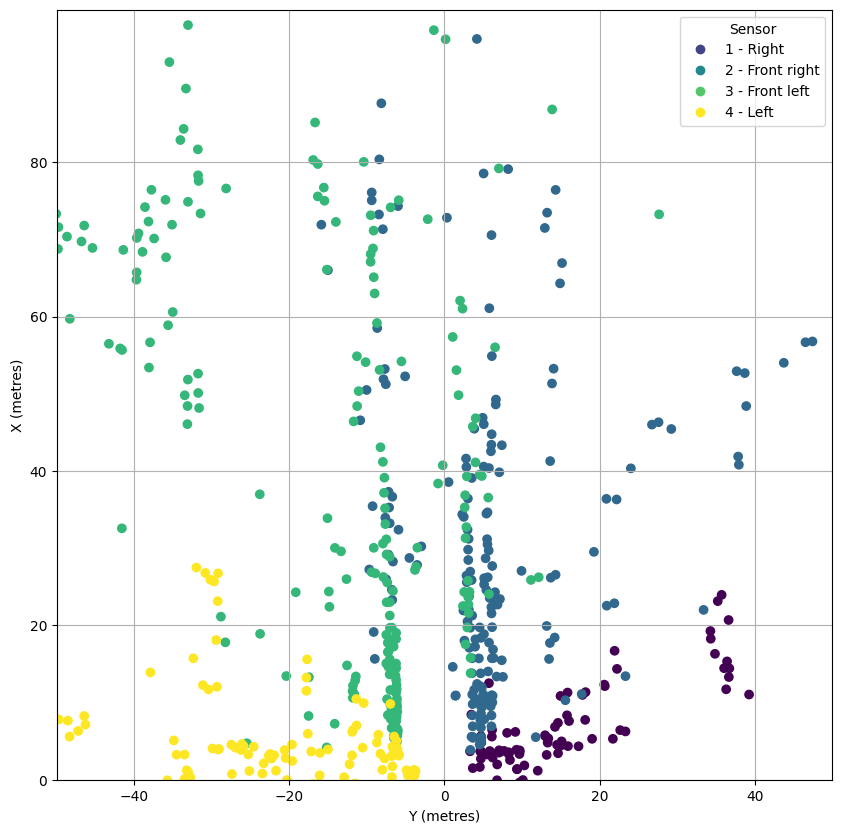

In [ ]:
import matplotlib.pyplot as plt

# Split the data into separate sensors
sensor_1 = pointcloud[pointcloud['sensor_id']==1]
sensor_2 = pointcloud[pointcloud['sensor_id']==2]
sensor_3 = pointcloud[pointcloud['sensor_id']==3]
sensor_4 = pointcloud[pointcloud['sensor_id']==4]

# Find unique timestamps and arange in increasing order
timestamps_1 = np.sort(np.unique(sensor_1['timestamp']))
timestamps_2 = np.sort(np.unique(sensor_2['timestamp']))
timestamps_3 = np.sort(np.unique(sensor_3['timestamp']))
timestamps_4 = np.sort(np.unique(sensor_4['timestamp']))

def read_frame(timestamp_1):
    # Read a single frame of data closest to the timestamp from sensor 1

    # Find the closest timestamps from the other sensors
    timestamp_2 = timestamps_2[np.argmin(np.abs(timestamp_1 - timestamps_2))]
    timestamp_3 = timestamps_3[np.argmin(np.abs(timestamp_1 - timestamps_3))]
    timestamp_4 = timestamps_4[np.argmin(np.abs(timestamp_1 - timestamps_4))]

    # Select the first frame (points that match the first timestamp)
    frame_1 = sensor_1[sensor_1['timestamp'] == timestamp_1]
    frame_2 = sensor_2[sensor_2['timestamp'] == timestamp_2]
    frame_3 = sensor_3[sensor_3['timestamp'] == timestamp_3]
    frame_4 = sensor_4[sensor_4['timestamp'] == timestamp_4]

    return np.concatenate((frame_1, frame_2, frame_3, frame_4))

# Select frame 10
timestamp_1 = timestamps_1[10]
print(f"timestamp = {timestamp_1*1e-6}")

# Read frame 10
frame = read_frame(timestamp_1)
print(f"The pointcloud frame has {frame.size} points")

# Plot pointcloud frame
max_range = np.max(pointcloud['range_sc'])
plt.figure(figsize=(10,10))
sc = plt.scatter(-frame['y_cc'], frame['x_cc'], c=frame['sensor_id'])
plt.xlabel('Y (metres)')
plt.ylabel('X (metres)')
plt.xlim([-max_range/2, max_range/2])
plt.ylim([0, max_range])
plt.grid()

# Create legend
handles, _ = sc.legend_elements(prop="colors", num=4)
plt.legend(handles, ['1 - Right', '2 - Front right', '3 - Front left', '4 - Left'], title="Sensor")
plt.show()

# Step 4: Visualise camera

One tricky part of reading data from multiple sensors is time synchronisation. We have now read 4 pointclouds from 4 radars, but we want to see what that looks like from the camera. Luckily, the "scenes.json" file contains matching camera images for each radar timestamp so we can synchronise the radar and camera data.

The scenes.json format is as follow:

```
- sequence_name
- category
- first_timestamp
- last_timestamp
- scenes
    - [timestamp_i]
        - sensor_id
        - prev_timestamp
        - next_timestamp
        - prev_timestamp_same_sensor
        - next_timestamp_same_sensor
        - odometry_timestamp
        - odometry_index
        - image_name
    - [timestamp_i+1]
    ...
```

We can use the `image_name` field to find the correct camera image.

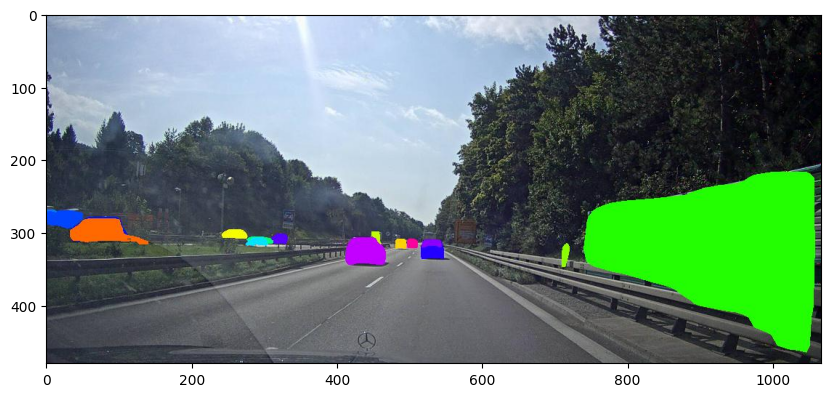

In [ ]:
import json
import matplotlib.image as img

# Read the scenes.json file
with open('data/sequence_106/scenes.json') as f:
    scenes = json.load(f)['scenes']

# Find the corresponding timestamp
camera_filename = scenes[str(timestamps_1[10])]['image_name']

# Read camera image
image = img.imread(f"data/sequence_106/camera/{camera_filename}")

# Displaying the image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

# Step 5: Segmenting pointclouds

Not all points are useful for every use case. Therefore, we need to be able to extract useful points by segmenting the pointcloud. This can be done using boolean indexing in numpy arrays.

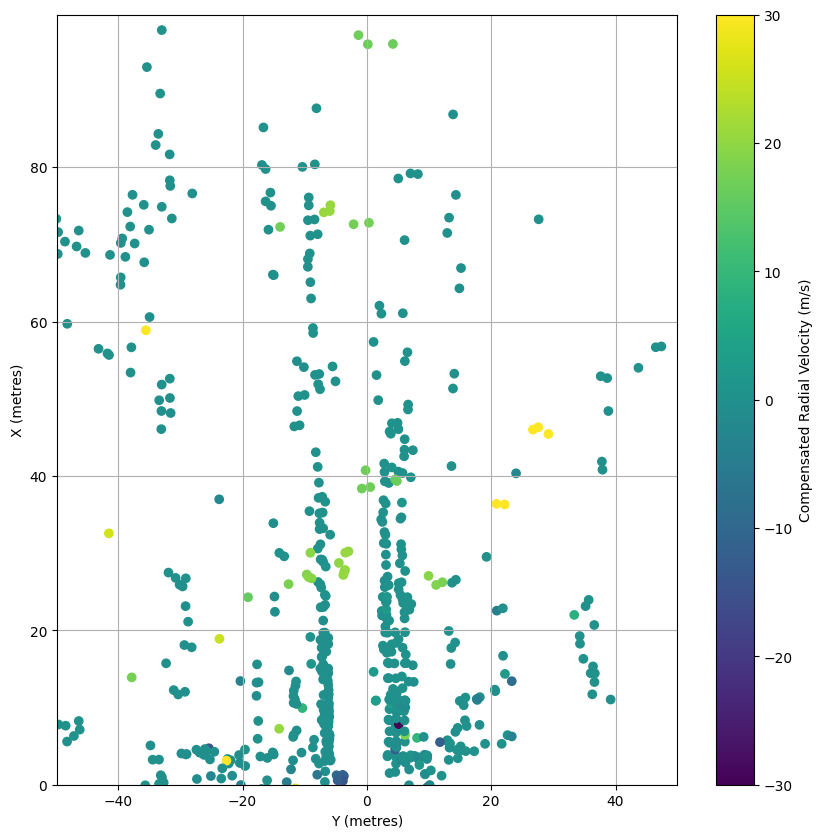

In [ ]:
# Read frame 10
timestamp_1 = timestamps_1[10]
frame = read_frame(timestamp_1)

# Plot pointcloud frame with compensated radial velocity in m/s
plt.figure(figsize=(10,10))
sc = plt.scatter(-frame['y_cc'], frame['x_cc'], c=frame['vr_compensated'], vmin=-30, vmax=30)
plt.xlabel('Y (metres)')
plt.ylabel('X (metres)')
plt.xlim([-max_range/2, max_range/2])
plt.ylim([0, max_range])
plt.grid()

# Plot colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Compensated Radial Velocity (m/s)")
plt.show()

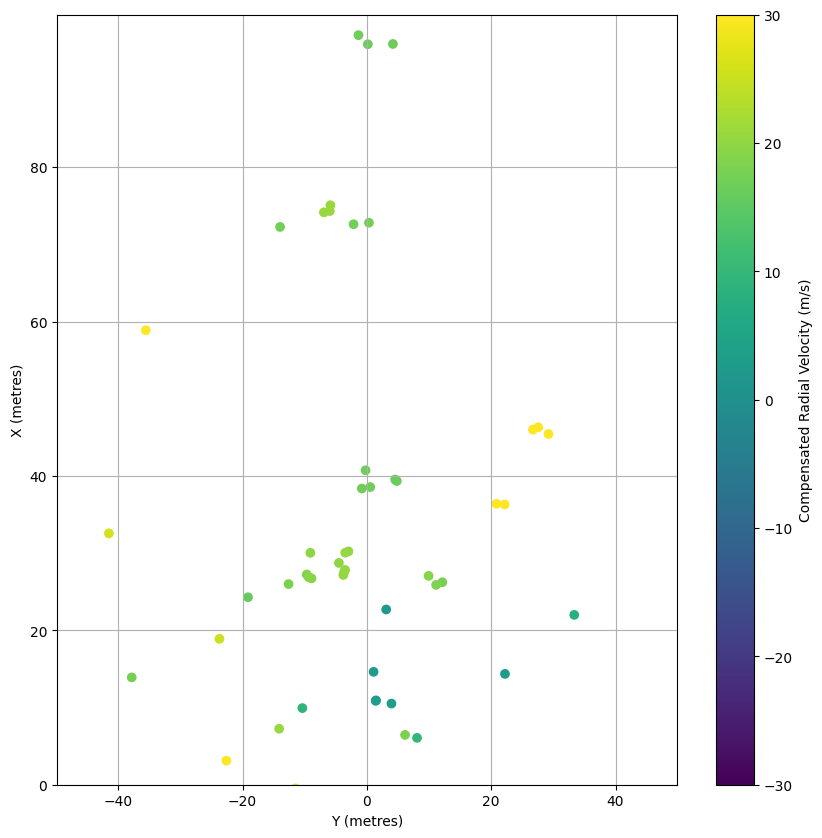

In [ ]:
# Only show points where the compensated velocity is greater than 2 m/s
segmented_frame = frame[frame['vr_compensated'] > 2]

# Plot pointcloud frame with compensated radial velocity in km/h
plt.figure(figsize=(10,10))
sc = plt.scatter(-segmented_frame['y_cc'], segmented_frame['x_cc'], c=segmented_frame['vr_compensated'], vmin=-30, vmax=30)
plt.xlabel('Y (metres)')
plt.ylabel('X (metres)')
plt.xlim([-max_range/2, max_range/2])
plt.ylim([0, max_range])
plt.grid()

# Plot colorbar
cbar = plt.colorbar(sc)
cbar.set_label("Compensated Radial Velocity (m/s)")
plt.show()

# Step 6: Animate pointcloud and camera

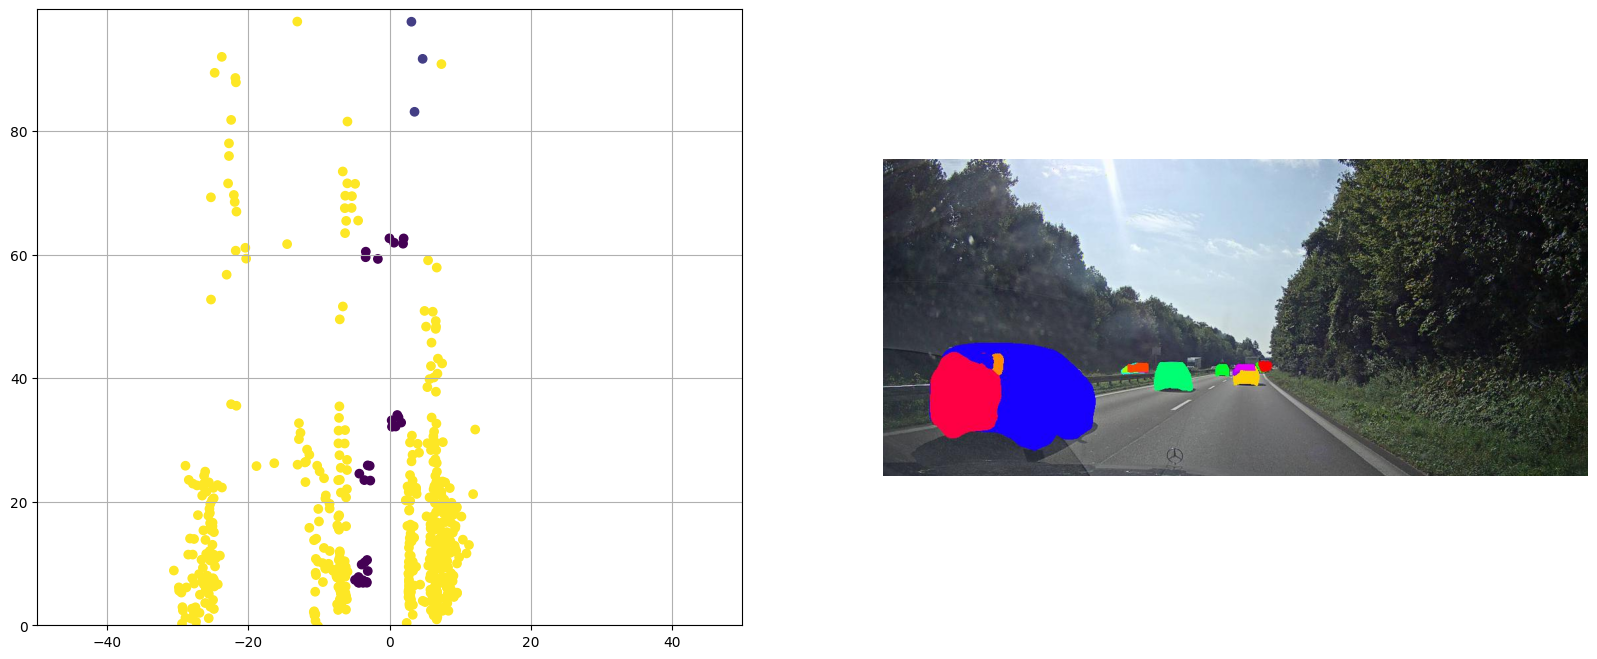

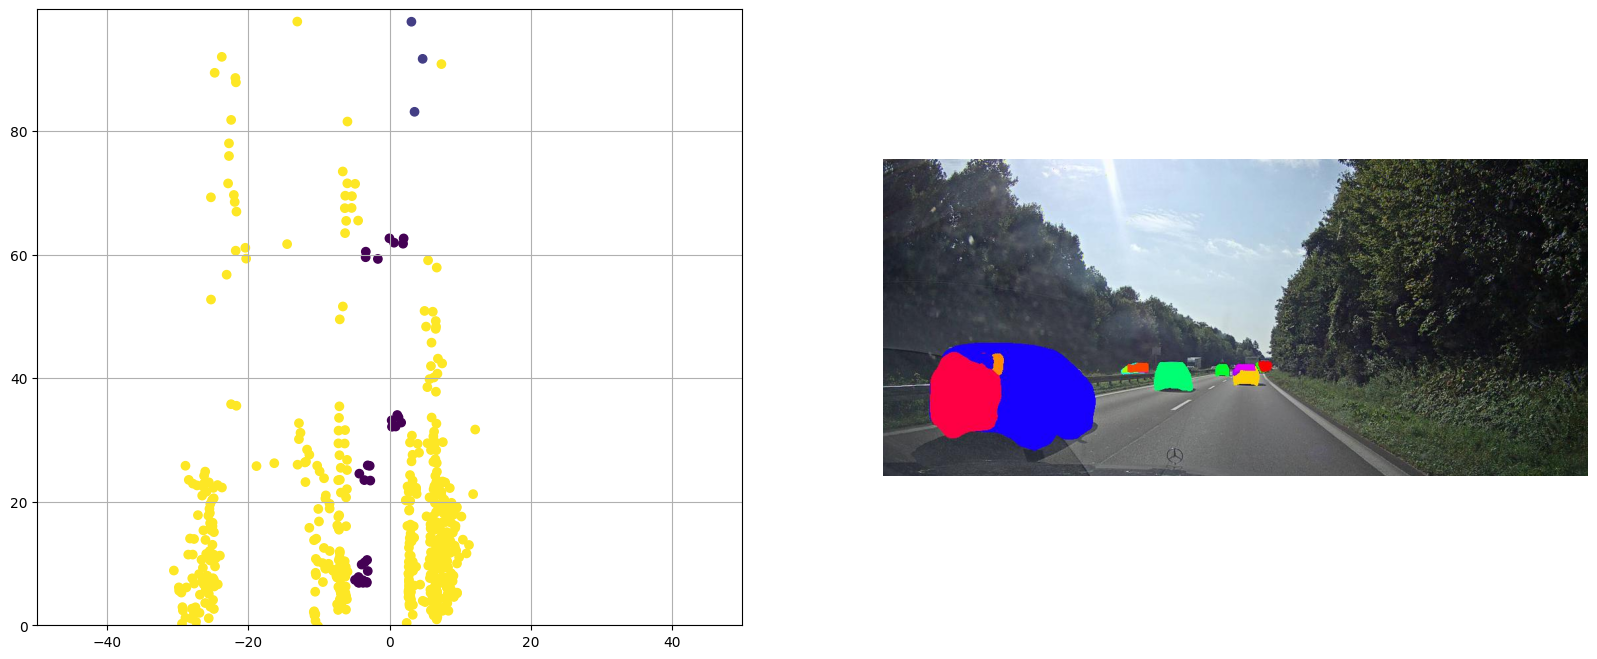

In [ ]:
import time

pfig, axes = plt.subplots(1, 2, figsize=(20, 8))

scat1 = axes[0].scatter([], [])

axes[0].set_xlim([-max_range/2, max_range/2])
axes[0].set_ylim([0, max_range])
axes[0].grid()

im = axes[1].imshow(np.zeros((9, 20, 3)))
axes[1].axis("off")

display_handle = display(pfig, display_id=True)

try:
    for i in range(0, timestamps_1.size, 20):
        timestamp_1 = timestamps_1[i]

        frame = read_frame(timestamp_1)

        camera_filename = scenes[str(timestamp_1)]['image_name']
        image = img.imread(f"data/sequence_106/camera/{camera_filename}")

        # --- Update scatter data ---
        scat1.set_offsets(np.c_[-frame['y_cc'], frame['x_cc']])
        scat1.set_array(frame['label_id'])

        im.set_data(image)

        display_handle.update(pfig)
        time.sleep(1)
except KeyboardInterrupt:
    pass

# Challenges

1. Plot a pointcloud frame showing radial velocity (`vr` field)
2. Print a list of all label_id classes that appear in sequence_106
3. Show the static scene only (points less than 0.5m/s) , using the vr_compensated field
4. At the beginning of the script, two sequences were imported, but we have only used sequence_106. Show the first pointcloud frame and camera image from the other sequence (sequence_87).
5. Proximity detection - For timestamp 22547463510351 of sequence_87, find passenger car points inside the bounding box `y_cc` = [-5, +5], `x_cc` = [-5, +5]. Plot the detected points over the original pointcloud and plot the bounding box as well.